### Reusable 


Imports


In [18]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

File References

In [19]:
apollo12_cat_directory = '../NASAResources/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB/'
filename = 'xa.s12.00.mhz.1969-12-16HR00_evid00006'



#### Read the first table of the Apollo 12 Grade B as cvs file


In [20]:
csv_file = pd.read_csv(f'{apollo12_cat_directory}{filename}.csv')
csv_file

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1969-12-16T00:00:00.178000,0.000000,0.000000e+00
1,1969-12-16T00:00:00.328943,0.150943,-5.580000e-15
2,1969-12-16T00:00:00.479887,0.301887,-1.120000e-14
3,1969-12-16T00:00:00.630830,0.452830,-1.670000e-14
4,1969-12-16T00:00:00.781774,0.603774,-2.230000e-14
...,...,...,...
572418,1969-12-17T00:00:02.894981,86402.716981,-1.770000e-14
572419,1969-12-17T00:00:03.045925,86402.867920,-2.540000e-14
572420,1969-12-17T00:00:03.196868,86403.018868,-3.010000e-14
572421,1969-12-17T00:00:03.347811,86403.169811,-4.160000e-14



#### Read the first table of the Apollo 12 Grade B as mseed file


In [21]:
mseed_file = read(f'{apollo12_cat_directory}{filename}.mseed')
mseed_file[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1969-12-16T00:00:00.178000Z
         endtime: 1969-12-17T00:00:03.498755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

#### Testing on potential arrival times, both abs and rel, from the csv 


In [22]:
#row = csv_file.iloc[10750]

In [23]:
#arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
#arrival_time


In [24]:
#arrival_time_rel = row['time_rel(sec)']
#arrival_time_rel

#### Arrival from mseed

In [25]:
# This is how you get the data and the time, which is in seconds
trace = mseed_file.traces[0].copy()
trace_times = trace.times()
trace_data = trace.data

# # Start time of trace (another way to get the relative arrival time using datetime)
# starttime = trace.stats.starttime.datetime
# arrival = (arrival_time - starttime).total_seconds()
# arrival

### Plott & Filtering 

Filter the data using different bandpasses for testing purposes

In [26]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 3.0


# Going to create a separate trace for the filter data
stream_filt = mseed_file.copy()
#stream_filt2 = mseed_file.copy()

stream_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
#stream_filt2.filter('bandpass',freqmin=minfreq2,freqmax=maxfreq2)

trace_filt = stream_filt.traces[0].copy()
trace_times_filt = trace_filt.times()
trace_data_filt = trace_filt.data

In [27]:
# To better see the patterns, we will create a spectrogram using the scipy function
# It requires the sampling rate, which we can get from the miniseed header as shown a few cells above
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(trace_data_filt, trace_filt.stats.sampling_rate)

In [28]:
# Plot the time series and spectrogram
# fig = plt.figure(figsize=(10, 10))
# ax = plt.subplot(2, 1, 1)

# # Plot trace
# ax.plot(trace_times_filt,trace_data_filt)

# # Mark detection
# ax.axvline(x = arrival, color='red',label='Detection')
# ax.legend(loc='upper left')

# # Make the plot pretty
# ax.set_xlim([min(trace_times_filt),max(trace_times_filt)])
# ax.set_ylabel('Velocity (m/s)')
# ax.set_xlabel('Time (s)')

# ax2 = plt.subplot(2, 1, 2)
# vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
# ax2.set_xlim([min(trace_times_filt),max(trace_times_filt)])
# ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
# ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
# ax2.axvline(x=arrival, c='red')
# cbar = plt.colorbar(vals, orientation='horizontal')
# cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

### STA/LTA algrotihm 
A STA/LTA algorithm moves two time windows of two lengths (one short, one long) across the seismic data. 
The algorithm calculates the average amplitude in both windows, and calculates the ratio between them. 
#### If the data contains an earthquake, then the short-term window containing the earthquake will be much larger than the long-term window -- resulting in a detection. 

Text(0, 0.5, 'Characteristic function')

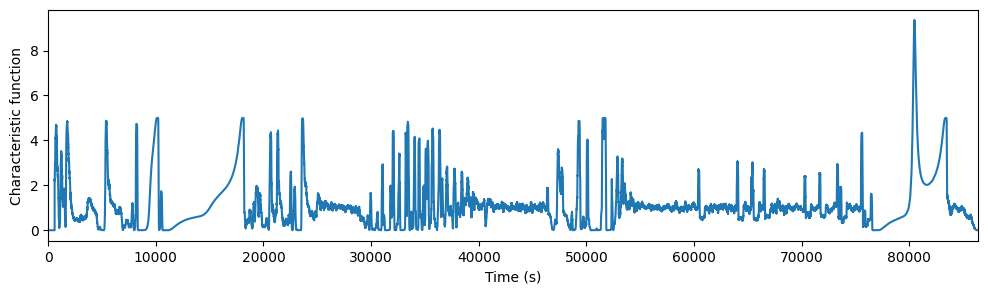

In [29]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace 
# df stands for delta frequency or data frequency 
df = trace.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 120
lta_len = 600

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(trace_data, int(sta_len * df), int(lta_len * df))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(trace_times,cft)
ax.set_xlim([min(trace_times),max(trace_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

Next, we define the values of the characteristic function (i.e. amplitude ratio between short-term and long-term windows) where we flag a seismic detection. These values are called triggers. There are two types of triggers -- "on" and "off", defined as follows:

1. "on" : If the characteristic function is above this value, then a seismic event begins. 
2. "off" : If the characteristic function falls below this value (after an "on" trigger), than a seismic event ends. 

In [1]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 2
thr_off = 0.75
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    # ax.axvline(x = trace_times[triggers[0]], color='red', label='Trig. On')
    # ax.axvline(x = trace_times[triggers[1]], color='purple', label='Trig. Off')
    ax.axvline(x = trace_times[triggers[0]], color='red')
    ax.axvline(x = trace_times[triggers[1]], color='purple')

# Plot seismogram
ax.plot(trace_times,trace_data)
ax.set_xlim([min(trace_times),max(trace_times)])
ax.legend()

NameError: name 'np' is not defined